# Gesture recognition networks

### Imports

In [23]:
import os
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm import tqdm
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt

### Configuration

In [40]:

class CONFIG:
    model_path = 'BestModel3.pt'
    num_epochs = 100
    lr = 1e-4
    batch_size = 10
    img_size = 224
    dataset = "division_5" # division_5 / division_4 depends on dataset
    rgb_depth = "RGB" # RGB / Depth depends on dataset
    classes1 = ['LeftProfile', 'LightOn', 'OcclusionPaper', 'RightProfile'] 
    classes2 = ['Neutral', 'OcclusionEyes', 'OcclusionMouth', 'OpenMouth', 'Smile']  


### Creating sorted classes for dataset



In [41]:
cfg = CONFIG()
data_dir = r".\..\EURECOM_Kinect_Face_Dataset\EURECOM_Kinect_Face_Dataset"
destination_dir = r".\HeadDataset"
os.makedirs(destination_dir, exist_ok=True)

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    
    if os.path.isdir(folder_path):
        print(f"Processing folder: {folder}")
        
        # Loop through each class subfolder #
        for class_folder in os.listdir(folder_path):
            class_folder_path = os.path.join(folder_path, class_folder)
            
            if os.path.isdir(class_folder_path) and class_folder == "s2":
                print(f"  Class folder: {class_folder}")
                
                for class_Sfolder in os.listdir(class_folder_path):
                    class_Subfolder_path = os.path.join(class_folder_path, class_Sfolder)
                    
                    if os.path.isdir(class_Subfolder_path) and class_Sfolder == cfg.rgb_depth:
                        if class_Sfolder == "Depth":
                            class_Subfolder_path = os.path.join(class_Subfolder_path,"DepthBMP")
                        print(f"    Class Sub folder: {class_Sfolder}")

                        for filename in os.listdir(class_Subfolder_path):
                            file_path = os.path.join(class_Subfolder_path, filename)
                            if cfg.dataset == "division_4":
                                # Left Profile
                                if os.path.isfile(file_path) and "LeftProfile" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\001", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\001", filename))
                                # Light on
                                if os.path.isfile(file_path) and "LightOn" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\002", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\002", filename))
                                # RightProfile
                                if os.path.isfile(file_path) and "RightProfile" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\008", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\008", filename))
                                # OcclusionPaper
                                if os.path.isfile(file_path) and "OcclusionPaper" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\006", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\006", filename))
                            if cfg.dataset == "division_5":
                                # Neutral
                                if os.path.isfile(file_path) and "Neutral" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\003", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\003", filename))
                                # OcclusionEyes
                                if os.path.isfile(file_path) and "OcclusionEyes" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\004", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\004", filename))
                                # OcclusionMouth
                                if os.path.isfile(file_path) and "OcclusionMouth" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\005", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\005", filename))
                                # OpenMouth
                                if os.path.isfile(file_path) and "OpenMouth" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\007", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\007", filename))
                                # Smile
                                if os.path.isfile(file_path) and "Smile" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"\009", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"\009", filename))

Processing folder: 0001
  Class folder: s2
    Class Sub folder: RGB
        Moving file: rgb_0001_s2_Neutral.bmp
        Moving file: rgb_0001_s2_OcclusionEyes.bmp
        Moving file: rgb_0001_s2_OcclusionMouth.bmp
        Moving file: rgb_0001_s2_OpenMouth.bmp
        Moving file: rgb_0001_s2_Smile.bmp
Processing folder: 0002
  Class folder: s2
    Class Sub folder: RGB
        Moving file: rgb_0002_s2_Neutral.bmp
        Moving file: rgb_0002_s2_OcclusionEyes.bmp
        Moving file: rgb_0002_s2_OcclusionMouth.bmp
        Moving file: rgb_0002_s2_OpenMouth.bmp
        Moving file: rgb_0002_s2_Smile.bmp
Processing folder: 0003
  Class folder: s2
    Class Sub folder: RGB
        Moving file: rgb_0003_s2_Neutral.bmp
        Moving file: rgb_0003_s2_OcclusionEyes.bmp
        Moving file: rgb_0003_s2_OcclusionMouth.bmp
        Moving file: rgb_0003_s2_OpenMouth.bmp
        Moving file: rgb_0003_s2_Smile.bmp
Processing folder: 0004
  Class folder: s2
    Class Sub folder: RGB
        Mo

### CNN structure

In [28]:
class CNN6Conv6FC(nn.Module):
    def __init__(self, num_classes):
        super(CNN6Conv6FC, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(512 * 3 * 3, 1024)  
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, num_classes)  
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        
        x = self.fc6(x)
        
        return x


### Dataloader

In [42]:
cfg = CONFIG()
transform = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),  
    transforms.ToTensor(),        
    transforms.Grayscale(), 
    transforms.Normalize((0.5), (0.5))  
])

augmented_transform = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),  
    transforms.RandomRotation(30),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),  
    transforms.RandomAffine(10),  
    transforms.ToTensor(),  
    transforms.Grayscale(),  
    transforms.Normalize((0.5,), (0.5,))  
])


dataset = datasets.ImageFolder(root=r'.\HeadDataset', transform=transform)
augmented_dataset = datasets.ImageFolder(root=r'.\HeadDataset', transform=augmented_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset =  data.random_split(dataset, [train_size, test_size])

combined_dataset = data.ConcatDataset([augmented_dataset, train_dataset])




trainloader =  data.DataLoader(combined_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=2)
testloader =  data.DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)
num_classes = len(dataset.class_to_idx)
print(num_classes)

5


In [6]:
torch.save(model.state_dict(), cfg.model_path)

NameError: name 'model' is not defined

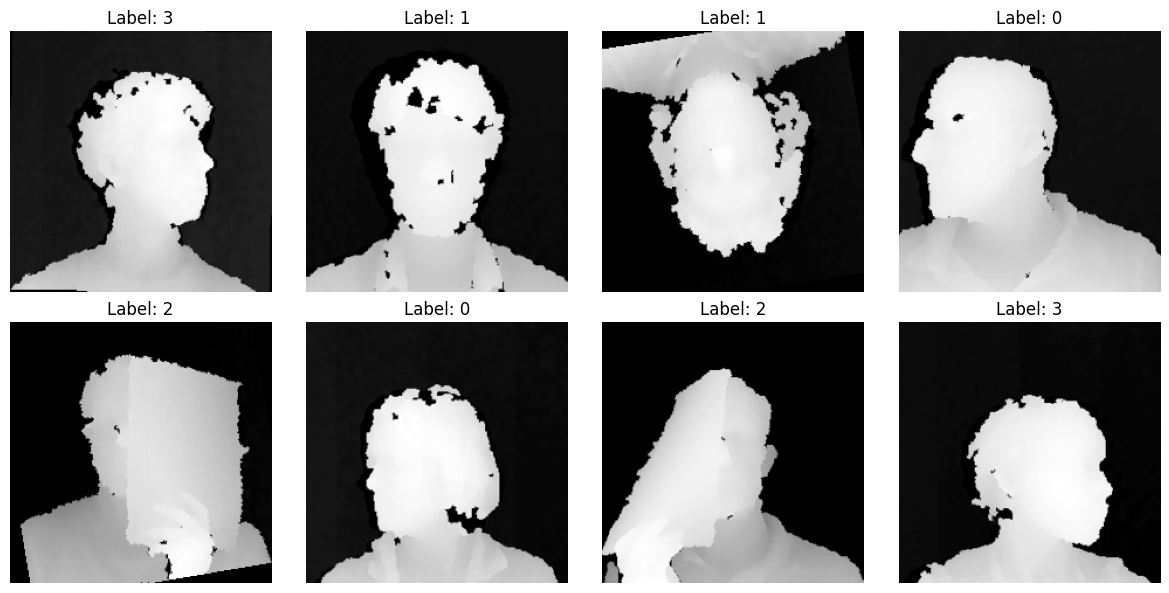

In [30]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

random_indices = np.random.choice(images.size(0), 8, replace=False)
images = images[random_indices]
labels = labels[random_indices]

# Convert images to numpy and plot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(8):
    ax = axes[i//4, i%4]
    image = images[i].squeeze(0).numpy() 
    ax.imshow(image, cmap='gray')  
    ax.axis('off')
    ax.set_title(f"Label: {labels[i].item()}")

plt.tight_layout()
plt.show()


### NET Setup and training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNN6Conv6FC(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)  # Adam optimizer with learning rate

Using device: cuda


In [19]:
best_accuracy = 0.0
all_labels = []
all_predictions = []
loss_timeline = []
acc_timeline = []
val_loss_timeline = []
val_acc_timeline = []

for epoch in range(cfg.num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Create a progress bar for the current epoch
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{cfg.num_epochs}", unit="batch")

    for i, (inputs, labels) in enumerate(progress_bar):  
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # Update progress bar with current loss and accuracy
        progress_bar.set_postfix({
            'loss': loss.item(),
            'accuracy': (correct_predictions / total_predictions) * 100
        })

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    loss_timeline.append(epoch_loss)
    acc_timeline.append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{cfg.num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.2f}%")

    # Validation loop
    model.eval()  
    val_running_loss = 0.0
    val_preds = []
    val_labels = []
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():  
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    validation_accuracy = (correct_predictions / total_predictions) * 100
    val_loss_timeline.append(val_running_loss / len(testloader))
    val_acc_timeline.append(validation_accuracy)
    print(f"Validation Accuracy: {validation_accuracy:.2f}%")
    
    if validation_accuracy > best_accuracy:
        torch.save(model.state_dict(), cfg.model_path)
        
    # if epoch == cfg.num_epochs - 1:  
    conf_train_matrix = confusion_matrix(all_labels, all_predictions)
    conf_val_matrix = confusion_matrix(val_labels, val_preds)
print("Training finished.")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_train_matrix, display_labels=['Neutral', 'OcclusionEyes', 'OcclusionMouth', 'OpenMouth'] )
disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_val_matrix, display_labels=['Neutral', 'OcclusionEyes', 'OcclusionMouth', 'OpenMouth'] )


Epoch 1/100: 100%|██████████| 37/37 [00:14<00:00,  2.56batch/s, loss=1.01, accuracy=28.6] 


Epoch 1/100 - Loss: 2.5064 - Accuracy: 28.61%
Validation Accuracy: 36.59%


Epoch 2/100: 100%|██████████| 37/37 [00:14<00:00,  2.49batch/s, loss=2.13, accuracy=30.2]


Epoch 2/100 - Loss: 2.4637 - Accuracy: 30.25%
Validation Accuracy: 31.71%


Epoch 3/100: 100%|██████████| 37/37 [00:14<00:00,  2.54batch/s, loss=2.51, accuracy=27.8]


Epoch 3/100 - Loss: 2.4664 - Accuracy: 27.79%
Validation Accuracy: 31.71%


Epoch 4/100: 100%|██████████| 37/37 [00:14<00:00,  2.61batch/s, loss=2.84, accuracy=25.3]


Epoch 4/100 - Loss: 2.5451 - Accuracy: 25.34%
Validation Accuracy: 31.71%


Epoch 5/100:  89%|████████▉ | 33/37 [00:13<00:01,  2.41batch/s, loss=2.86, accuracy=29.4]


KeyboardInterrupt: 

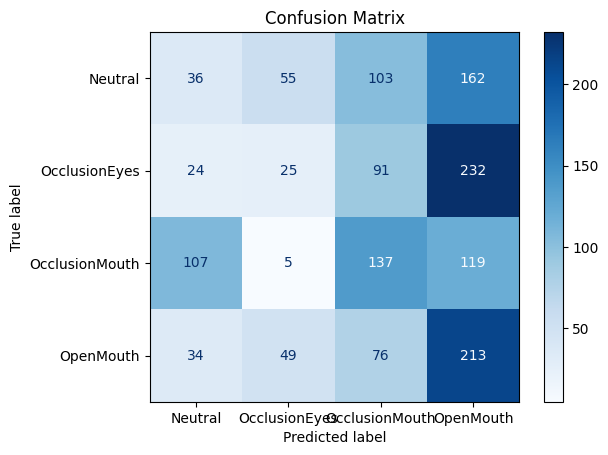

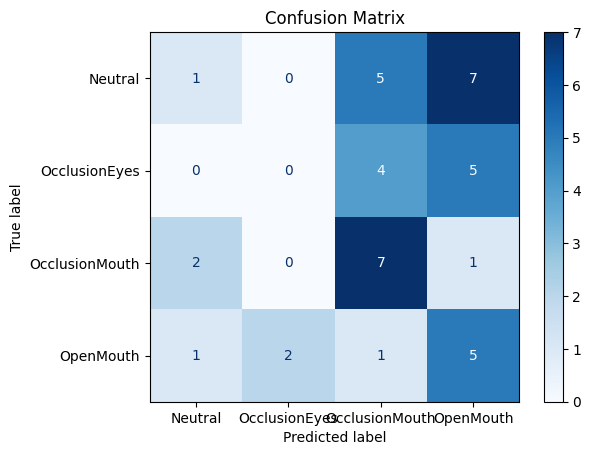

In [ ]:
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

disp2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

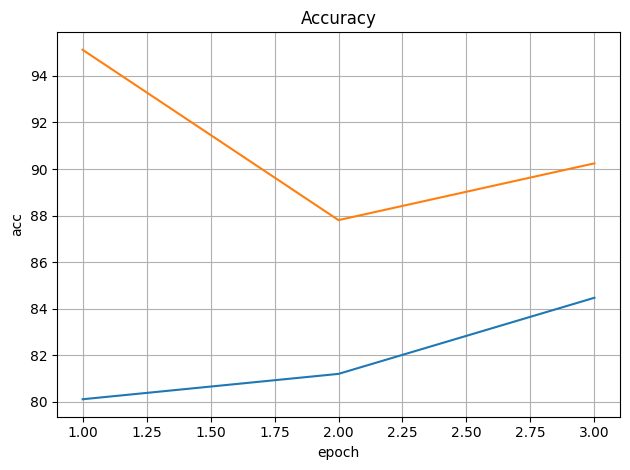

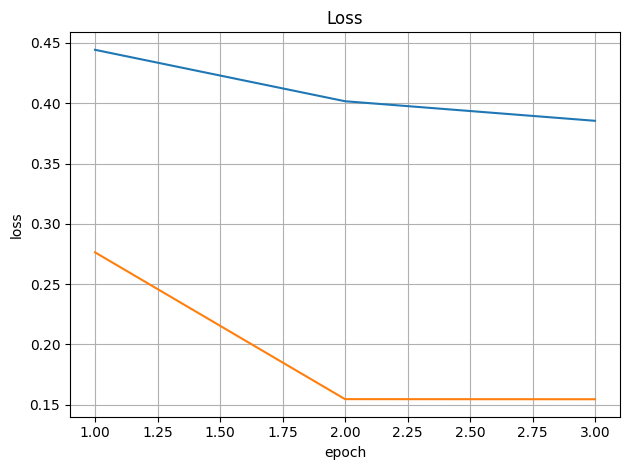

In [ ]:
plt.plot(np.linspace(1, cfg.num_epochs, cfg.num_epochs),acc_timeline)
plt.plot(np.linspace(1, cfg.num_epochs, cfg.num_epochs),val_acc_timeline)
plt.title("Accuracy")
plt.ylabel("acc")
plt.xlabel("epoch")
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(np.linspace(1, cfg.num_epochs, cfg.num_epochs),loss_timeline)
plt.plot(np.linspace(1, cfg.num_epochs, cfg.num_epochs),val_loss_timeline)
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.grid()
plt.tight_layout()
plt.show()

Using device: cuda


C:\Users\david\AppData\Local\Temp\ipykernel_33352\3092420551.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('BestModel2.pt')


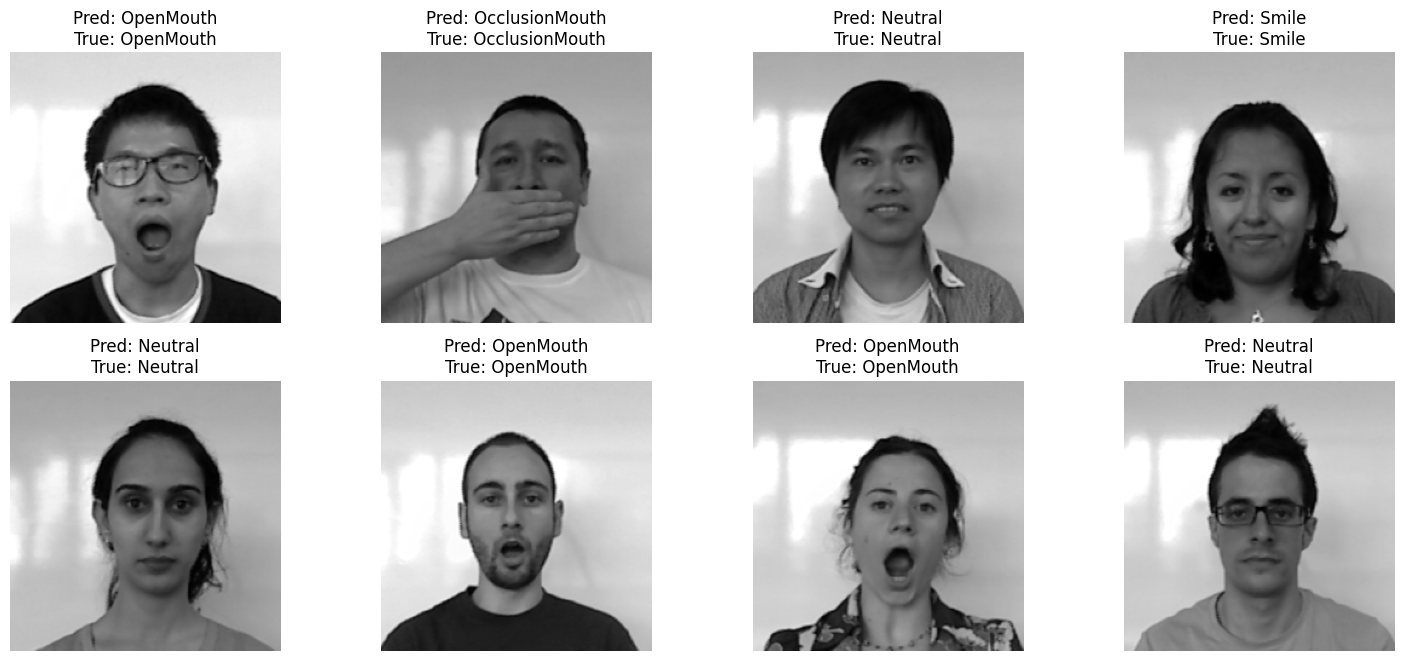

In [43]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = CNN6Conv6FC(num_classes=5).to(device)
state_dict = torch.load('BestModel2.pt')
model.load_state_dict(state_dict)
model.eval()

class_labels = cfg.classes1 if cfg.dataset == "division_4" else cfg.classes2 

random_batch = next(iter(testloader))  
images, labels = random_batch

indices = random.sample(range(len(images)), 8)

selected_images = images[indices]
selected_labels = labels[indices]

selected_images = selected_images.to(device)

with torch.no_grad():  
    outputs = model(selected_images)

_, predicted_classes = torch.max(outputs, 1)

plt.figure(figsize=(15, 10))  

for i in range(8):
    img = selected_images[i].cpu().squeeze().numpy()  
    predicted_label = class_labels[predicted_classes[i].item()]  
    true_label = class_labels[selected_labels[i].item()]  

    plt.subplot(3, 4, i + 1)  
    plt.imshow(img, cmap='gray')  
    plt.title(f'Pred: {predicted_label}\nTrue: {true_label}')
    plt.axis('off')  

plt.tight_layout()
plt.show()
